In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ccxt
import keras_tuner as kt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Configuración de GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [24]:
# Fuente de los datos
exchange = ccxt.binance()

# Obtener datos históricos
symbol = 'BTC/MXN'
timeframe = '1h'
since = exchange.parse8601('2023-01-01T00:00:00Z')
limit = 5000
ohlc = exchange.fetch_ohlcv(symbol, timeframe, since, limit)

In [25]:
# Convertir a DataFrame
df = pd.DataFrame(ohlc,
    columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

print(df.head())

                          open       high        low      close    volume
timestamp                                                                
2024-05-29 15:00:00  1152513.0  1222880.0  1149898.0  1154680.0  0.178535
2024-05-29 16:00:00  1151976.0  1153714.0  1150730.0  1150730.0  0.016489
2024-05-29 17:00:00  1149953.0  1156310.0  1149953.0  1155403.0  0.001466
2024-05-29 18:00:00  1144952.0  1147208.0  1144952.0  1147208.0  0.038433
2024-05-29 19:00:00  1150475.0  1153626.0  1147208.0  1147208.0  0.020860


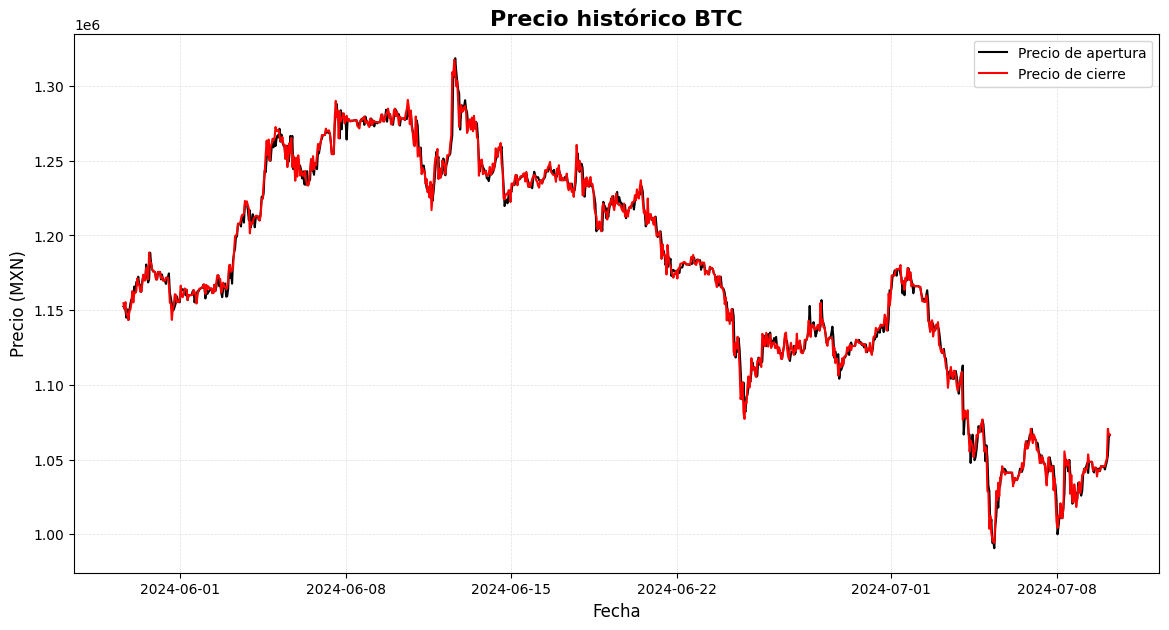

In [26]:
# Ver los datos
plt.figure(figsize=(14, 7))
plt.plot(df.index, df["open"], label="Precio de apertura",
    color='black', linewidth=1.5)
plt.plot(df.index, df["close"], label="Precio de cierre",
    color='red', linewidth=1.5)
plt.title("Precio histórico BTC", fontsize=16, fontweight='bold')
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Precio (MXN)", fontsize=12)
plt.legend()
plt.grid(visible=True, color='lightgrey', linestyle='--',
    linewidth=0.5, alpha=0.7)
plt.show()

In [35]:
# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df[['close']])
print(df_scaled[:5])

[[0.49618384]
 [0.48396843]
 [0.49841973]
 [0.47307661]
 [0.47307661]]


In [36]:
# Preparar los datos en secuencias
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(df_scaled)):
    X.append(df_scaled[i-sequence_length:i, 0])
    y.append(df_scaled[i, 0])
X, y = np.array(X), np.array(y)
print(X[0][:5])

[0.49618384 0.48396843 0.49841973 0.47307661 0.47307661]


In [37]:
# Dividir en conjuntos de entrenamiento (80%), validación (10%) y prueba (10%)
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]
print(X_train[0][:5])

[0.49618384 0.48396843 0.49841973 0.47307661 0.47307661]


In [38]:
# Transformar en un formato compatible con el modelo LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train[0][:5])

[[0.49618384]
 [0.48396843]
 [0.49841973]
 [0.47307661]
 [0.47307661]]


In [79]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))

    # Ajuste del modelo LSTM
    model.add(LSTM(units=hp.Int('units', min_value=80, max_value=200, step=10),
        return_sequences=False))

    # Capa de salida
    model.add(Dense(units=1))

    # Compilar el modelo
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

# Crear el optimizador
tuner = kt.Hyperband(build_model,
    objective='val_loss',
    max_epochs=100,
    factor=3,
    directory='models',
    project_name='crypto_lstm_tuning_5')

# Ajustar hiperparámetros
tuner.search(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

Trial 13 Complete [00h 00m 07s]
val_loss: 0.009001154452562332

Best val_loss So Far: 0.0047092619352042675
Total elapsed time: 00h 01m 30s


In [73]:
best_model = tuner.get_best_models(num_models=1)[0]

/home/andres/Documentos/univ/maestria/3ro/ap/deep-learning-lab/.venv39/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [72]:
# Mostrar los hiperparámetros de los mejores modelos
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=10)

# Mostrar los hiperparámetros de los mejores modelos
for i, hp in enumerate(best_hyperparameters):
    print(f"Mejores hiperparámetros para el modelo {i + 1}")
    for key, value in hp.values.items():
        print(f"{key}: {value}")
    print("\n")

Mejores hiperparámetros para el modelo 1
units: 80
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0


Mejores hiperparámetros para el modelo 2
units: 200
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0


Mejores hiperparámetros para el modelo 3
units: 100
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0


Mejores hiperparámetros para el modelo 4
units: 110
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0


Mejores hiperparámetros para el modelo 5
units: 90
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0


Mejores hiperparámetros para el modelo 6
units: 190
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0


Mejores hiperparámetros para el modelo 7
units: 160
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0


Mejores hiperparámetros para el modelo 8
units: 120
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0


Me

In [74]:
# Entrenamiento del modelo
best_model.fit(np.concatenate((X_train, X_val), axis=0), np.concatenate((y_train, y_val), axis=0)
, epochs=20, batch_size=32)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0028
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.0460e-04
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.9642e-04
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.6902e-04
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.1235e-04
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.7250e-04
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.1409e-04
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.2124e-04
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.9228e-04
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.2446e-04
Epoch 13/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.6345e-04
Epoch 14/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.4767e-04
Epoch 15/20
27/27 ━━━━━━━━━

In [75]:
# Predicción en el conjunto de prueba
predicted_price = best_model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
print(predicted_price[:5])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[[1035919.8 ]
 [1036348.5 ]
 [1037354.75]
 [1038760.2 ]
 [1039986.56]]


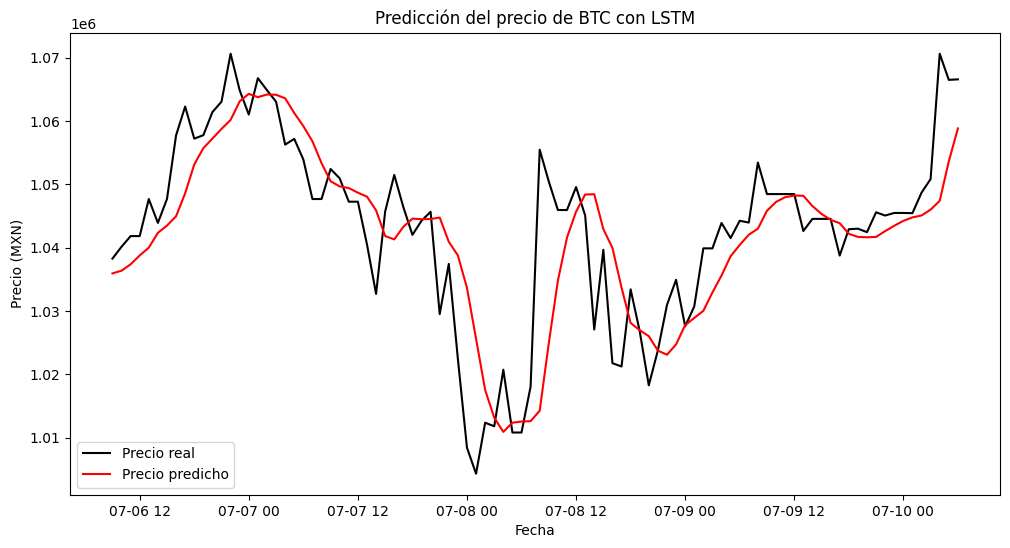

In [76]:
# Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(df.index[train_size + val_size + sequence_length:], y_test_original,
    color = 'black', label='Precio real')
plt.plot(df.index[train_size + val_size + sequence_length:], predicted_price,
    color='red', label='Precio predicho')
plt.title("Predicción del precio de BTC con LSTM")
plt.xlabel("Fecha")
plt.ylabel("Precio (MXN)")
plt.legend()
plt.show()

In [77]:
# Evaluar el modelo
mse = mean_squared_error(y_test_original, predicted_price)
mae = mean_absolute_error(y_test_original, predicted_price)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, predicted_price)
mape = np.mean(
    np.abs((y_test_original - predicted_price) / y_test_original)) * 100

# Imprimir las métricas
print(f"Error cuadrático promedio (MSE): {mse:.2f}")
print(f"Error absoluto promedio (MAE): {mae:.2f}")
print(f"Raíz del error cuadrático promedio (RMSE): {rmse:.2f}")
print(f"Coeficiente de determinación (R²): {r2:.2f}")
print(f"Error porcentual absoluto promedio (MAPE): {mape:.2f}%")

Error cuadrático promedio (MSE): 85188673.34
Error absoluto promedio (MAE): 6180.87
Raíz del error cuadrático promedio (RMSE): 9229.77
Coeficiente de determinación (R²): 0.60
Error porcentual absoluto promedio (MAPE): 0.59%
